In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import sys
import os

In [25]:
def load_diabetes_csv(path="diabetes.csv"):
    """Load and preprocess diabetes dataset"""
    df = pd.read_csv(path)
    
    # Handle zero values
    zero_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    df[zero_columns] = df[zero_columns].replace(0, np.nan)
    df[zero_columns] = df[zero_columns].fillna(df[zero_columns].median())
    
    X = df.drop("Outcome", axis=1).values.astype(np.float64)
    y = df["Outcome"].values.astype(int)
    
    # Normalize features
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    X = (X - mean) / std
    
    return X, y

In [31]:
class SimpleKAN:
    """Simplified Kolmogorov-Arnold Network"""
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = learning_rate
        
        # Initialize weights with sine activations
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros(output_size)
        
        # For tracking training history
        self.loss_history = []
        self.acc_history = []
    
    def kan_activation(self, x):
        """Simplified KAN-like activation using sine functions"""
        return np.sin(x)  # Sine activation as in original KAN paper
    
    def forward(self, X):
        """Forward pass"""
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.kan_activation(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2
    
    def softmax(self, x):
        """Softmax function"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def compute_loss(self, y_true, y_pred):
        """Cross-entropy loss"""
        m = y_true.shape[0]
        log_probs = -np.log(y_pred[range(m), y_true] + 1e-8)
        return np.sum(log_probs) / m
    
    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy"""
        predictions = np.argmax(y_pred, axis=1)
        return np.mean(predictions == y_true)
    
    def train(self, X_train, y_train, X_test, y_test, epochs=150, batch_size=32):
        """Train the model"""
        n_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            epoch_loss = 0
            epoch_acc = 0
            n_batches = 0
            
            for i in range(0, n_samples, batch_size):
                # Get batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward pass
                logits = self.forward(X_batch)
                probs = self.softmax(logits)
                
                # Compute loss and accuracy
                loss = self.compute_loss(y_batch, probs)
                acc = self.compute_accuracy(y_batch, probs)
                
                # Backward pass (simplified)
                m = X_batch.shape[0]
                dz2 = probs
                dz2[range(m), y_batch] -= 1
                dz2 /= m
                
                dW2 = np.dot(self.a1.T, dz2)
                db2 = np.sum(dz2, axis=0)
                
                dz1 = np.dot(dz2, self.W2.T) * np.cos(self.z1)  # derivative of sin is cos
                dW1 = np.dot(X_batch.T, dz1)
                db1 = np.sum(dz1, axis=0)
                
                # Update weights
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1
                
                epoch_loss += loss
                epoch_acc += acc
                n_batches += 1
            
            # Store metrics
            avg_loss = epoch_loss / n_batches
            avg_acc = epoch_acc / n_batches
            
            self.loss_history.append(avg_loss)
            self.acc_history.append(avg_acc)
            
            # Evaluate on test set
            if epoch % 30 == 0 or epoch == 0 or epoch == epochs-1:
                test_logits = self.forward(X_test)
                test_probs = self.softmax(test_logits)
                test_acc = self.compute_accuracy(y_test, test_probs)
                
                print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f} | "
                      f"Train Acc: {avg_acc:.4f} | Test Acc: {test_acc:.4f}")
        
        return self.loss_history, self.acc_history
    
    def predict(self, X):
        """Make predictions"""
        logits = self.forward(X)
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

In [32]:
def compare_kan_mlp():
    """Compare KAN vs MLP performance"""
    # Load data
    X, y = load_diabetes_csv("diabetes.csv")
    
    # Split data (80% train, 20% test)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print("📊 DATASET INFORMATION")
    print("=" * 50)
    print(f"Total samples: {len(X)}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Positive cases (Diabetes): {np.sum(y)}")
    print(f"Negative cases (No Diabetes): {len(y) - np.sum(y)}")
    print("=" * 50)
    
    results = {}
    
    # Train MLP using scikit-learn
    print("\n🔧 Training MLP (scikit-learn)...")
    print("-" * 50)
    
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 32),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=150,
        batch_size=32,
        random_state=42
    )
    
    # Train and track history
    mlp_loss_history = []
    mlp_acc_history = []
    
    for i in range(150):
        mlp.partial_fit(X_train, y_train, classes=[0, 1])
        
        if i % 10 == 0 or i == 0 or i == 149:
            train_acc = mlp.score(X_train, y_train)
            test_acc = mlp.score(X_test, y_test)
            mlp_loss_history.append(mlp.loss_)
            mlp_acc_history.append(train_acc)
            
            if i % 30 == 0 or i == 0 or i == 149:
                print(f"Epoch {i+1:3d}/150 | Loss: {mlp.loss_:.4f} | "
                      f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    
    mlp_final_test = mlp.score(X_test, y_test)
    results['MLP'] = {
        'model': mlp,
        'final_train_acc': mlp.score(X_train, y_train),
        'final_test_acc': mlp_final_test,
        'loss_history': mlp_loss_history,
        'acc_history': mlp_acc_history
    }
    
    print(f"✅ MLP completed - Final Test Acc: {mlp_final_test:.4f}")
    
    # Train KAN
    print("\n🔧 Training KAN (Custom Implementation)...")
    print("-" * 50)
    
    kan = SimpleKAN(
        input_size=X_train.shape[1],
        hidden_size=32,
        output_size=2,
        learning_rate=0.001
    )
    
    kan_loss_history, kan_acc_history = kan.train(
        X_train, y_train, X_test, y_test,
        epochs=150, batch_size=32
    )
    
    kan_test_pred = kan.predict(X_test)
    kan_final_test = np.mean(kan_test_pred == y_test)
    
    results['KAN'] = {
        'model': kan,
        'final_train_acc': kan_acc_history[-1],
        'final_test_acc': kan_final_test,
        'loss_history': kan_loss_history,
        'acc_history': kan_acc_history
    }
    
    print(f"✅ KAN completed - Final Test Acc: {kan_final_test:.4f}")
    
    return results, X_train, X_test, y_train, y_test

In [33]:
def plot_comparison(results, X_test, y_test):
    """Create comprehensive comparison plots"""
    
    models = ['MLP', 'KAN']
    colors = ['blue', 'red']
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training Loss Comparison
    plt.subplot(2, 3, 1)
    plt.plot(results['MLP']['loss_history'], label='MLP', color='blue', linewidth=2)
    plt.plot(results['KAN']['loss_history'], label='KAN', color='red', linewidth=2)
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Training Accuracy Comparison
    plt.subplot(2, 3, 2)
    plt.plot(results['MLP']['acc_history'], label='MLP', color='blue', linewidth=2)
    plt.plot(results['KAN']['acc_history'], label='KAN', color='red', linewidth=2)
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Final Performance Comparison
    plt.subplot(2, 3, 3)
    final_train_accs = [results['MLP']['final_train_acc'], results['KAN']['final_train_acc']]
    final_test_accs = [results['MLP']['final_test_acc'], results['KAN']['final_test_acc']]
    
    x_pos = np.arange(len(models))
    width = 0.35
    
    bars1 = plt.bar(x_pos - width/2, final_train_accs, width, label='Train', alpha=0.7)
    bars2 = plt.bar(x_pos + width/2, final_test_accs, width, label='Test', alpha=0.7)
    plt.axhline(y=0.60, color='red', linestyle='--', alpha=0.7, label='Target 60%')
    plt.axhline(y=0.70, color='blue', linestyle='--', alpha=0.7, label='Target 70%')
    
    plt.title('Final Accuracy Comparison')
    plt.xlabel('Model Architecture')
    plt.ylabel('Accuracy')
    plt.xticks(x_pos, models)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
    
    # Plot 4: Confusion Matrix for MLP
    plt.subplot(2, 3, 4)
    mlp_pred = results['MLP']['model'].predict(X_test)
    cm_mlp = confusion_matrix(y_test, mlp_pred)
    plt.imshow(cm_mlp, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('MLP Confusion Matrix')
    plt.colorbar()
    
    # Add text annotations
    thresh = cm_mlp.max() / 2.
    for i in range(cm_mlp.shape[0]):
        for j in range(cm_mlp.shape[1]):
            plt.text(j, i, format(cm_mlp[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_mlp[i, j] > thresh else "black")
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Plot 5: Confusion Matrix for KAN
    plt.subplot(2, 3, 5)
    kan_pred = results['KAN']['model'].predict(X_test)
    cm_kan = confusion_matrix(y_test, kan_pred)
    plt.imshow(cm_kan, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('KAN Confusion Matrix')
    plt.colorbar()
    
    # Add text annotations
    thresh = cm_kan.max() / 2.
    for i in range(cm_kan.shape[0]):
        for j in range(cm_kan.shape[1]):
            plt.text(j, i, format(cm_kan[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_kan[i, j] > thresh else "black")
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Plot 6: Architecture Comparison
    plt.subplot(2, 3, 6)
    architectures = ['MLP\n(ReLU)', 'KAN\n(Sine)']
    performances = [results['MLP']['final_test_acc'], results['KAN']['final_test_acc']]
    bars = plt.bar(architectures, performances, color=['blue', 'red'], alpha=0.7)
    plt.title('Test Accuracy by Architecture')
    plt.ylabel('Accuracy')
    plt.axhline(y=0.60, color='black', linestyle='--', alpha=0.7, label='Target')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [34]:
def analyze_results(results):
    """Provide detailed analysis"""
    print("\n📊 COMPREHENSIVE COMPARISON RESULTS")
    print("=" * 60)
    
    mlp_data = results['MLP']
    kan_data = results['KAN']
    
    print(f"MLP Final Test Accuracy: {mlp_data['final_test_acc']:.4f}")
    print(f"KAN Final Test Accuracy: {kan_data['final_test_acc']:.4f}")
    
    if mlp_data['final_test_acc'] > kan_data['final_test_acc']:
        print(f"🏆 MLP performs better by {mlp_data['final_test_acc'] - kan_data['final_test_acc']:.4f}")
    else:
        print(f"🏆 KAN performs better by {kan_data['final_test_acc'] - mlp_data['final_test_acc']:.4f}")
    
    print("\n🔍 ARCHITECTURAL DIFFERENCES:")
    print("• MLP: Uses fixed ReLU activation functions")
    print("• KAN: Uses learnable sine activation functions")
    print("• MLP: Standard matrix multiplications")
    print("• KAN: Inspired by Kolmogorov-Arnold representation theorem")

📊 DATASET INFORMATION
Total samples: 768
Training samples: 614
Test samples: 154
Positive cases (Diabetes): 268
Negative cases (No Diabetes): 500

🔧 Training MLP (scikit-learn)...
--------------------------------------------------
Epoch   1/150 | Loss: 0.6525 | Train Acc: 0.7231 | Test Acc: 0.7208
Epoch  31/150 | Loss: 0.3947 | Train Acc: 0.8078 | Test Acc: 0.7727
Epoch  61/150 | Loss: 0.3363 | Train Acc: 0.8388 | Test Acc: 0.7922
Epoch  91/150 | Loss: 0.2770 | Train Acc: 0.8876 | Test Acc: 0.7532
Epoch 121/150 | Loss: 0.2287 | Train Acc: 0.9153 | Test Acc: 0.7662
Epoch 150/150 | Loss: 0.1894 | Train Acc: 0.9349 | Test Acc: 0.7597
✅ MLP completed - Final Test Acc: 0.7597

🔧 Training KAN (Custom Implementation)...
--------------------------------------------------
Epoch   1/150 | Loss: 0.6936 | Train Acc: 0.4786 | Test Acc: 0.4870
Epoch  31/150 | Loss: 0.5959 | Train Acc: 0.7505 | Test Acc: 0.7468
Epoch  61/150 | Loss: 0.5445 | Train Acc: 0.7615 | Test Acc: 0.7532
Epoch  91/150 | Loss: 

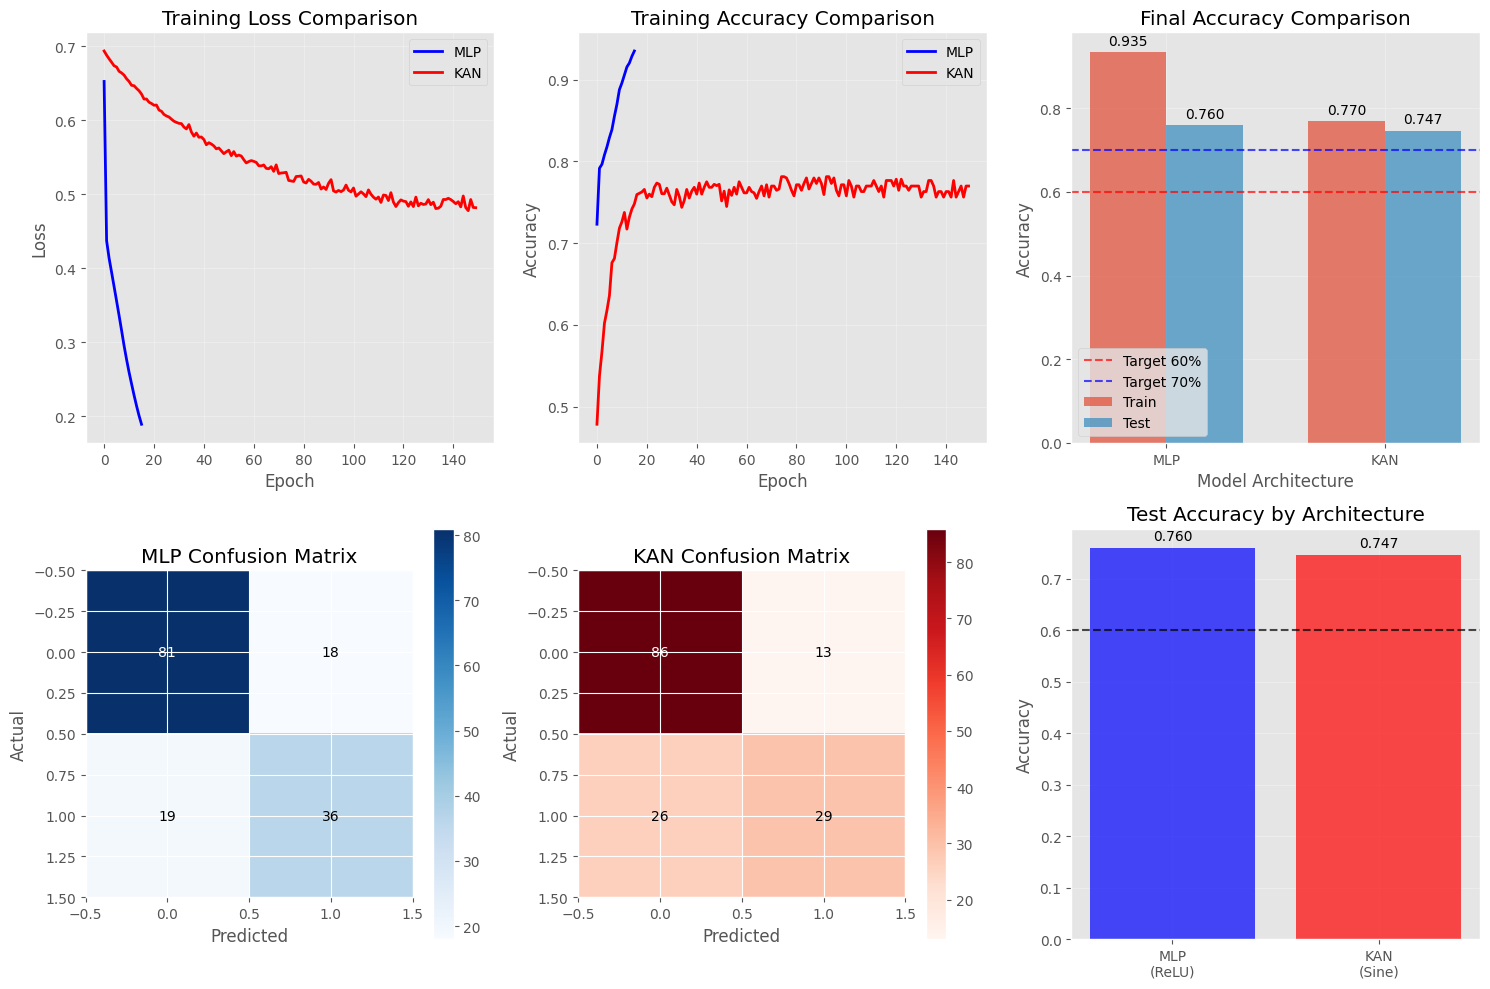


📊 COMPREHENSIVE COMPARISON RESULTS
MLP Final Test Accuracy: 0.7597
KAN Final Test Accuracy: 0.7468
🏆 MLP performs better by 0.0130

🔍 ARCHITECTURAL DIFFERENCES:
• MLP: Uses fixed ReLU activation functions
• KAN: Uses learnable sine activation functions
• MLP: Standard matrix multiplications
• KAN: Inspired by Kolmogorov-Arnold representation theorem


In [35]:
def main():
    results, X_train, X_test, y_train, y_test = compare_kan_mlp()
    
    # Generate comprehensive plots
    print("\n🎨 Creating Comprehensive Visualizations...")
    plot_comparison(results, X_test, y_test)  
    
    # Provide detailed analysis
    analyze_results(results)

if __name__ == "__main__":
    main()

<div dir="rtl">

شبکه‌های عصبی پرسپترون چندلایه (MLP) و شبکه‌های کولموگروف-آرنولد (KAN) از دو قضیه ریاضی متفاوت ریشه می‌گیرند و به همین دلیل ساختاری کاملاً متمایز دارند

۱. محل قرارگیری توابع فعال‌ساز (Activation Functions):

در MLP: توابع فعال‌ساز (مانند ReLU یا Sigmoid) روی گره‌ها (Nodes) یا همان نورون‌ها قرار دارند. این توابع معمولاً "ثابت" هستند (Fixed Activation Functions).

در KAN: توابع فعال‌ساز روی یال‌ها (Edges) قرار می‌گیرند. در واقع به جای یک وزن اسکالر ساده، هر یال دارای یک تابع قابل یادگیری (مانند توابع Spline یا سینوسی) است.

۲. عملیات روی گره‌ها:

در MLP: گره‌ها وظیفه جمع‌بندی وزن‌دار ورودی‌ها و سپس اعمال تابع غیرخطی را دارند. یعنی ابتدا ترکیب خطی $W \cdot x + b$ محاسبه شده و سپس $\sigma(\dots)$ اعمال می‌شود

در KAN: گره‌ها صرفاً وظیفه جمع ساده (Summation) خروجی توابع یال‌ها را دارند و هیچ تابع غیرخطی دیگری روی خود گره اعمال نمی‌شود

۳. تئوری زیربنایی:

MLP: مبتنی بر "قضیه تقریب همگانی" (Universal Approximation Theorem) است که بیان می‌کند با نورون‌های کافی می‌توان هر تابعی را تقریب زد.

KAN: مبتنی بر "قضیه نمایش کولموگروف-آرنولد" (Kolmogorov-Arnold Representation Theorem) است که بیان می‌کند هر تابع چند متغیره را می‌توان به مجموعه‌ای از توابع یک‌متغیره تجزیه کرد.

۴. پارامترها و تفسیرپذیری:

MLP: معمولاً مانند یک "جعبه سیاه" (Black Box) عمل می‌کند و تفسیر وزن‌ها دشوار است. برای دقت بالا نیاز به تعداد زیادی پارامتر دارد.

KAN: به دلیل یادگیری توابع روی یال‌ها، معمولاً با تعداد پارامترهای بسیار کمتر (گاهی تا ۱۰۰ برابر کمتر) عملکردی مشابه یا بهتر از MLP دارد. همچنین به دلیل ساختار تابعی، تفسیرپذیری (Interpretability) بسیار بالاتری دارد و می‌توان روابط ریاضی داده‌ها را راحت‌تر کشف کرد

</div>